##  Install the EVA4 packages, hosted @ github

In [1]:
!pip install git+https://git@github.com/ojhajayant/eva.git --upgrade 

  Cloning https://****@github.com/ojhajayant/eva.git to c:\users\ojhaj\appdata\local\temp\pip-req-build-dx3ehj2s
  Created wheel for eva: filename=eva-0.0.0-py3-none-any.whl size=41977 sha256=c167273a93d56366c7d512788e026337f1b2cf56d7662b5ff2118b08019d9145
  Stored in directory: C:\Users\ojhaj\AppData\Local\Temp\pip-ephem-wheel-cache-d7_6hvir\wheels\10\eb\41\b45f3a92716bbd015028946c2b4873f4622041a4db30191fb6
Successfully built eva
  Attempting uninstall: eva
    Found existing installation: eva 0.0.1
    Uninstalling eva-0.0.1:
      Successfully uninstalled eva-0.0.1


  Running command git clone -q 'https://****@github.com/ojhajayant/eva.git' 'C:\Users\ojhaj\AppData\Local\Temp\pip-req-build-dx3ehj2s'


# Import Libraries

In [1]:
from __future__ import print_function

import os
import sys
import warnings

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary

from week7.modular import cfg
from week7.modular.models import resnet18, s5_s6_custom_model_mnist, s7_custom_model_cifar10, QuizDNN
from week7.modular import preprocess
from week7.modular import preprocess_albumentations
from week7.modular import test
from week7.modular import train
from week7.modular import utils
from week7.modular import lr_finder
from torch.optim.lr_scheduler import ReduceLROnPlateau

sys.path.append('./')
global args
args = cfg.args
args.IPYNB_ENV = True
#Use albumentations lib for image-augmentation
#if below flag is false, usual torchvision 
#transforms are applied.
args.use_albumentations = True

### Save the config file, with all default/provided/required configuration

In [2]:
print("The config used for this run are being saved @ {}".format(os.path.join(args.prefix, 'config_params.txt')))
utils.write(vars(args), os.path.join(args.prefix, 'config_params.txt'))

The config used for this run are being saved @ data\config_params.txt


### Calculate mean & std for Normalization

In [3]:
args.dataset = 'CIFAR10'
mean, std = preprocess.get_dataset_mean_std()
mean_tuple = (mean[0], mean[1], mean[2])
std_tuple = (std[0], std[1], std[2])

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


###  Dataloader Arguments & Test/Train Dataloaders

In [4]:
if np.ndim(mean) ==0:
    if args.use_albumentations:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data((mean,), (std,))
    else:
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data_albumentations((mean,), (std,))    
else:
    if args.use_albumentations:
        print("Using albumentation lib for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = \
            preprocess_albumentations.preprocess_data_albumentations(mean_tuple, std_tuple)
    else:
        print("Using torchvison for image-augmentation & other transforms")
        train_dataset, test_dataset, train_loader, test_loader = preprocess.preprocess_data(mean_tuple, std_tuple)

Using albumentation lib for image-augmentation & other transforms
************
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Stats from Train Data]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
[Stats from Test Data]
 - Numpy Shape: (10000, 32, 32, 3)
 - Tensor Shape: torch.Size([10000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


torch.Size([64, 3, 32, 32])
torch.Size([64])
Saving plot for a sample to ascertain RF required for edges & gradient D:\PG-ML\eva4\week10\./data/data_stats.png


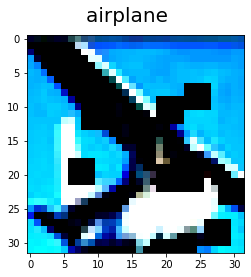

In [6]:
preprocess.get_data_stats(train_dataset, test_dataset, train_loader)

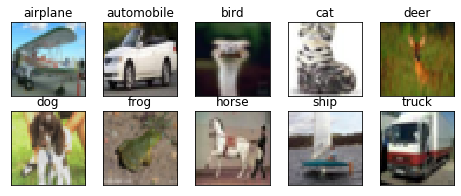

In [6]:
utils.plot_train_samples(train_loader)

### Using L1-regularization here 
(l1_weight = 0.000025, started out reusing some older assignment values, but works OK here too)

In [5]:
L1 = args.L1   
print("L1:", L1)
L2 = args.L2   
print("L2:", L2)

L1: True
L2: False


### detect the device being run on

In [6]:
device = torch.device("cuda" if args.cuda else "cpu")
print(device)

cuda


### Get the model loaded with summary

In [7]:
model = resnet18.ResNet18().to(device)
if args.dataset == 'CIFAR10':
    summary(model, input_size=(3, 32, 32))
elif args.dataset == 'MNIST':
    summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR-range test (using lr_finder)


Learning rate search finished. See the graph with {finder_name}.plot()


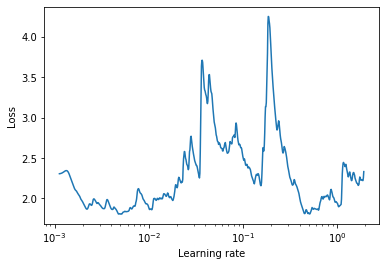

In [12]:
args.cmd = 'lr_find'
if args.cmd == 'lr_find':
    # criterion = F.nll_loss()
    # Enable L2-regularization with supplied value of weight decay, or keep it default-0
    if L2:
        weight_decay = args.l2_weight_decay
    else:
        weight_decay = 0
    criterion = nn.NLLLoss()
    optm = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=weight_decay)
    lr_find = lr_finder.LRFinder(model, optm, criterion, device=device)
    lr_find.range_test(train_loader, val_loader=test_loader, start_lr=1e-3, end_lr=2, num_iter=len(train_dataset)//args.batch_size, step_mode="exp")
    lr_find.plot()

### Best LR 

In [14]:
best_lr = lr_find.history['lr'][lr_find.history['loss'].index(lr_find.best_loss)]
print("Best LR: {}".format(best_lr))

Best LR: 0.004791748544349614


#### Will start from a LR which is slightly higher than this "best-LR", say 0.0055 & will come down to the min_lr=best_lr

## Training and Testing

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Model training starts on CIFAR10 dataset
Model training starts on CIFAR10 dataset
init_lr= 0.0055
factor= 0.9314545454545455
EPOCH: 1
LR: 0.0055


Loss=1.0219452381134033 Batch_id=781 Accuracy=51.13: 100%|███████████████████████████| 782/782 [01:59<00:00,  6.57it/s]



Test set: Average loss: 0.9787, Accuracy: 6532/10000 (65.32%)

validation-accuracy improved from 0 to 65.32, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-1_L1-1_L2-0_val_acc-65.32.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 2
LR: 0.0055


Loss=0.6768078804016113 Batch_id=781 Accuracy=68.56: 100%|███████████████████████████| 782/782 [02:01<00:00,  6.45it/s]



Test set: Average loss: 0.7829, Accuracy: 7314/10000 (73.14%)

validation-accuracy improved from 65.32 to 73.14, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-2_L1-1_L2-0_val_acc-73.14.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 3
LR: 0.0055


Loss=1.6049686670303345 Batch_id=781 Accuracy=75.57: 100%|███████████████████████████| 782/782 [02:02<00:00,  6.38it/s]



Test set: Average loss: 0.6557, Accuracy: 7784/10000 (77.84%)

validation-accuracy improved from 73.14 to 77.84, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-3_L1-1_L2-0_val_acc-77.84.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 4
LR: 0.0055


Loss=0.29958024621009827 Batch_id=781 Accuracy=78.72: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.34it/s]



Test set: Average loss: 0.6048, Accuracy: 7904/10000 (79.04%)

validation-accuracy improved from 77.84 to 79.04, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-4_L1-1_L2-0_val_acc-79.04.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 5
LR: 0.0055


Loss=1.6085076332092285 Batch_id=781 Accuracy=81.81: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.33it/s]



Test set: Average loss: 0.5455, Accuracy: 8177/10000 (81.77%)

validation-accuracy improved from 79.04 to 81.77, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-5_L1-1_L2-0_val_acc-81.77.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 6
LR: 0.0055


Loss=0.4576644003391266 Batch_id=781 Accuracy=83.38: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.33it/s]



Test set: Average loss: 0.5185, Accuracy: 8299/10000 (82.99%)

validation-accuracy improved from 81.77 to 82.99, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-6_L1-1_L2-0_val_acc-82.99.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 7
LR: 0.0055


Loss=0.5843388438224792 Batch_id=781 Accuracy=85.09: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.31it/s]



Test set: Average loss: 0.5018, Accuracy: 8333/10000 (83.33%)

validation-accuracy improved from 82.99 to 83.33, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-7_L1-1_L2-0_val_acc-83.33.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 8
LR: 0.0055


Loss=0.5487782955169678 Batch_id=781 Accuracy=86.53: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6135, Accuracy: 8051/10000 (80.51%)

Epoch     8: reducing learning rate of group 0 to 5.1230e-03.
EPOCH: 9
LR: 0.005123


Loss=0.4173271656036377 Batch_id=781 Accuracy=88.18: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.4436, Accuracy: 8568/10000 (85.68%)

validation-accuracy improved from 83.33 to 85.68, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-9_L1-1_L2-0_val_acc-85.68.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 10
LR: 0.005123


Loss=0.10443589091300964 Batch_id=781 Accuracy=88.99: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.4251, Accuracy: 8612/10000 (86.12%)

validation-accuracy improved from 85.68 to 86.12, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-10_L1-1_L2-0_val_acc-86.12.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 11
LR: 0.005123


Loss=0.21589121222496033 Batch_id=781 Accuracy=90.20: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.4413, Accuracy: 8640/10000 (86.40%)

validation-accuracy improved from 86.12 to 86.4, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-11_L1-1_L2-0_val_acc-86.4.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 4.7917e-03.
EPOCH: 12
LR: 0.004791748544349614


Loss=0.509494423866272 Batch_id=781 Accuracy=91.05: 100%|████████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4499, Accuracy: 8582/10000 (85.82%)

EPOCH: 13
LR: 0.004791748544349614


Loss=0.4215105473995209 Batch_id=781 Accuracy=91.73: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.31it/s]



Test set: Average loss: 0.4257, Accuracy: 8672/10000 (86.72%)

validation-accuracy improved from 86.4 to 86.72, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-13_L1-1_L2-0_val_acc-86.72.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 14
LR: 0.004791748544349614


Loss=0.663036584854126 Batch_id=781 Accuracy=92.27: 100%|████████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4436, Accuracy: 8671/10000 (86.71%)

EPOCH: 15
LR: 0.004791748544349614


Loss=0.43146446347236633 Batch_id=781 Accuracy=92.86: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.30it/s]



Test set: Average loss: 0.4252, Accuracy: 8753/10000 (87.53%)

validation-accuracy improved from 86.72 to 87.53, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-15_L1-1_L2-0_val_acc-87.53.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 16
LR: 0.004791748544349614


Loss=0.048458755016326904 Batch_id=781 Accuracy=93.29: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4797, Accuracy: 8599/10000 (85.99%)

EPOCH: 17
LR: 0.004791748544349614


Loss=0.3413403332233429 Batch_id=781 Accuracy=93.92: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4592, Accuracy: 8665/10000 (86.65%)

EPOCH: 18
LR: 0.004791748544349614


Loss=0.43292537331581116 Batch_id=781 Accuracy=94.34: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.28it/s]



Test set: Average loss: 0.4249, Accuracy: 8775/10000 (87.75%)

validation-accuracy improved from 87.53 to 87.75, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-18_L1-1_L2-0_val_acc-87.75.h5
EPOCH: 19
LR: 

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

0.004791748544349614


Loss=0.07611984014511108 Batch_id=781 Accuracy=94.86: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4788, Accuracy: 8693/10000 (86.93%)

EPOCH: 20
LR: 0.004791748544349614


Loss=0.19567722082138062 Batch_id=781 Accuracy=95.09: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.4293, Accuracy: 8806/10000 (88.06%)

validation-accuracy improved from 87.75 to 88.06, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-20_L1-1_L2-0_val_acc-88.06.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 21
LR: 0.004791748544349614


Loss=0.4058864414691925 Batch_id=781 Accuracy=95.40: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4581, Accuracy: 8760/10000 (87.60%)

EPOCH: 22
LR: 0.004791748544349614


Loss=0.016658365726470947 Batch_id=781 Accuracy=95.49: 100%|█████████████████████████| 782/782 [02:04<00:00,  6.27it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4260, Accuracy: 8779/10000 (87.79%)

EPOCH: 23
LR: 0.004791748544349614


Loss=0.0910746157169342 Batch_id=781 Accuracy=96.01: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.31it/s]



Test set: Average loss: 0.4085, Accuracy: 8848/10000 (88.48%)

validation-accuracy improved from 88.06 to 88.48, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-23_L1-1_L2-0_val_acc-88.48.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 24
LR: 0.004791748544349614


Loss=0.11772993206977844 Batch_id=781 Accuracy=96.09: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4517, Accuracy: 8820/10000 (88.20%)

EPOCH: 25
LR: 0.004791748544349614


Loss=0.043569713830947876 Batch_id=781 Accuracy=96.25: 100%|█████████████████████████| 782/782 [02:07<00:00,  6.14it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4526, Accuracy: 8811/10000 (88.11%)

EPOCH: 26
LR: 0.004791748544349614


Loss=0.0165519118309021 Batch_id=781 Accuracy=96.57: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4509, Accuracy: 8813/10000 (88.13%)

EPOCH: 27
LR: 0.004791748544349614


Loss=0.6572088599205017 Batch_id=781 Accuracy=96.76: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.28it/s]



Test set: Average loss: 0.4462, Accuracy: 8867/10000 (88.67%)

validation-accuracy improved from 88.48 to 88.67, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-27_L1-1_L2-0_val_acc-88.67.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 28
LR: 0.004791748544349614


Loss=0.07149454951286316 Batch_id=781 Accuracy=96.68: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4473, Accuracy: 8801/10000 (88.01%)

EPOCH: 29
LR: 0.004791748544349614


Loss=0.02174919843673706 Batch_id=781 Accuracy=97.02: 100%|██████████████████████████| 782/782 [02:05<00:00,  6.24it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4537, Accuracy: 8833/10000 (88.33%)

EPOCH: 30
LR: 0.004791748544349614


Loss=0.1215878427028656 Batch_id=781 Accuracy=97.10: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.26it/s]



Test set: Average loss: 0.4439, Accuracy: 8871/10000 (88.71%)

validation-accuracy improved from 88.67 to 88.71, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-30_L1-1_L2-0_val_acc-88.71.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 31
LR: 0.004791748544349614


Loss=0.06443503499031067 Batch_id=781 Accuracy=97.25: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.29it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4728, Accuracy: 8845/10000 (88.45%)

EPOCH: 32
LR: 0.004791748544349614


Loss=0.04024699330329895 Batch_id=781 Accuracy=97.29: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.27it/s]



Test set: Average loss: 0.4392, Accuracy: 8909/10000 (89.09%)

validation-accuracy improved from 88.71 to 89.09, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-32_L1-1_L2-0_val_acc-89.09.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 33
LR: 0.004791748544349614


Loss=0.2636076509952545 Batch_id=781 Accuracy=97.57: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4614, Accuracy: 8848/10000 (88.48%)

EPOCH: 34
LR: 0.004791748544349614


Loss=0.14968711137771606 Batch_id=781 Accuracy=97.76: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.31it/s]



Test set: Average loss: 0.4189, Accuracy: 8922/10000 (89.22%)

validation-accuracy improved from 89.09 to 89.22, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-34_L1-1_L2-0_val_acc-89.22.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 35
LR: 0.004791748544349614


Loss=0.025468915700912476 Batch_id=781 Accuracy=97.68: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8817/10000 (88.17%)

EPOCH: 36
LR: 0.004791748544349614


Loss=0.34144264459609985 Batch_id=781 Accuracy=97.90: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4788, Accuracy: 8836/10000 (88.36%)

EPOCH: 37
LR: 0.004791748544349614


Loss=0.18001043796539307 Batch_id=781 Accuracy=97.92: 100%|██████████████████████████| 782/782 [02:04<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4689, Accuracy: 8846/10000 (88.46%)

EPOCH: 38
LR: 0.004791748544349614


Loss=0.0033955276012420654 Batch_id=781 Accuracy=97.92: 100%|████████████████████████| 782/782 [02:04<00:00,  6.30it/s]



Test set: Average loss: 0.4423, Accuracy: 8931/10000 (89.31%)

validation-accuracy improved from 89.22 to 89.31, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-38_L1-1_L2-0_val_acc-89.31.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 39
LR: 0.004791748544349614


Loss=0.1714261770248413 Batch_id=781 Accuracy=98.06: 100%|███████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4615, Accuracy: 8916/10000 (89.16%)

EPOCH: 40
LR: 0.004791748544349614


Loss=0.011892557144165039 Batch_id=781 Accuracy=98.16: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.32it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4544, Accuracy: 8912/10000 (89.12%)

EPOCH: 41
LR: 0.004791748544349614


Loss=0.02934896945953369 Batch_id=781 Accuracy=98.14: 100%|██████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4482, Accuracy: 8927/10000 (89.27%)

EPOCH: 42
LR: 0.004791748544349614


Loss=0.007058978080749512 Batch_id=781 Accuracy=98.25: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.32it/s]



Test set: Average loss: 0.4353, Accuracy: 8963/10000 (89.63%)

validation-accuracy improved from 89.31 to 89.63, saving model to D:\PG-ML\eva4\week10\./saved_models/CIFAR10_model_epoch-42_L1-1_L2-0_val_acc-89.63.h5


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

EPOCH: 43
LR: 0.004791748544349614


Loss=0.015352129936218262 Batch_id=781 Accuracy=98.32: 100%|█████████████████████████| 782/782 [02:04<00:00,  6.26it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4848, Accuracy: 8872/10000 (88.72%)

EPOCH: 44
LR: 0.004791748544349614


Loss=0.0021514892578125 Batch_id=781 Accuracy=98.45: 100%|███████████████████████████| 782/782 [02:06<00:00,  6.18it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4606, Accuracy: 8916/10000 (89.16%)

EPOCH: 45
LR: 0.004791748544349614


Loss=0.1117103099822998 Batch_id=781 Accuracy=98.29: 100%|███████████████████████████| 782/782 [02:04<00:00,  6.28it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5037, Accuracy: 8857/10000 (88.57%)

EPOCH: 46
LR: 0.004791748544349614


Loss=0.014353275299072266 Batch_id=781 Accuracy=98.40: 100%|█████████████████████████| 782/782 [02:04<00:00,  6.30it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4812, Accuracy: 8906/10000 (89.06%)

EPOCH: 47
LR: 0.004791748544349614


Loss=0.016139358282089233 Batch_id=781 Accuracy=98.53: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.31it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4719, Accuracy: 8926/10000 (89.26%)

EPOCH: 48
LR: 0.004791748544349614


Loss=0.009338200092315674 Batch_id=781 Accuracy=98.64: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.34it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4690, Accuracy: 8911/10000 (89.11%)

EPOCH: 49
LR: 0.004791748544349614


Loss=0.003849327564239502 Batch_id=781 Accuracy=98.58: 100%|█████████████████████████| 782/782 [02:03<00:00,  6.35it/s]
  0%|                                                                                          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4693, Accuracy: 8953/10000 (89.53%)

EPOCH: 50
LR: 0.004791748544349614


Loss=0.05514270067214966 Batch_id=781 Accuracy=98.65: 100%|██████████████████████████| 782/782 [02:02<00:00,  6.39it/s]



Test set: Average loss: 0.4640, Accuracy: 8936/10000 (89.36%)



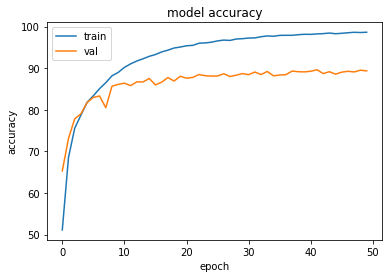

In [9]:
args.cmd = 'train'
print("Model training starts on {} dataset".format(args.dataset))
if args.cmd == 'train':
    print("Model training starts on {} dataset".format(args.dataset))
    if L2:
        weight_decay = args.l2_weight_decay
    else:
        weight_decay = 0
    lr = 0.0055 #Start here and have a factor to move to say 0.005123 from here, first
    factor = 0.005123/lr
    print("init_lr= {}".format(lr))
    print("factor= {}".format(factor))
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #mode 'min', for the test-loss 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=0, min_lr=best_lr, verbose=True)
    acc = 0
    val_acc = 0
    test_loss = 0
    #EPOCHS = args.epochs
    EPOCHS = 50

    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        print('LR:', optimizer.param_groups[0]['lr'])
        acc = train.train(model, device, train_loader, optimizer, epoch)
        val_acc, test_loss = test.test(model, device, test_loader, optimizer, epoch)
        scheduler.step(test_loss) #reduce the LR, if the test loss doesn't improve (i.e. decrease. mode-'min')
    utils.plot_acc()

### model-prediction & mislabelled images

Model inference starts on CIFAR10  dataset
Loaded the best model: CIFAR10_model_epoch-42_L1-1_L2-0_val_acc-89.63.h5 from last training session
The confusion-matrix and classification-report for this model are:
[[898   7  19  13   5   1   2   0  37  18]
 [  2 960   0   3   3   0   1   0   2  29]
 [ 32   0 859  24  36  20  16   7   3   3]
 [ 10   3  37 773  38  94  23  14   3   5]
 [  2   1  15  24 925   6  10  14   1   2]
 [  4   4  23  94  23 825   7  15   1   4]
 [  2   1  26  29  18  10 911   1   1   1]
 [  6   1  13  25  20  12   1 914   2   6]
 [ 13   7   3   3   2   0   4   0 953  15]
 [  4  31   1   2   2   1   2   1  11 945]]
              precision    recall  f1-score   support

    airplane       0.92      0.90      0.91      1000
  automobile       0.95      0.96      0.95      1000
        bird       0.86      0.86      0.86      1000
         cat       0.78      0.77      0.78      1000
        deer       0.86      0.93      0.89      1000
         dog       0.85      0.82 

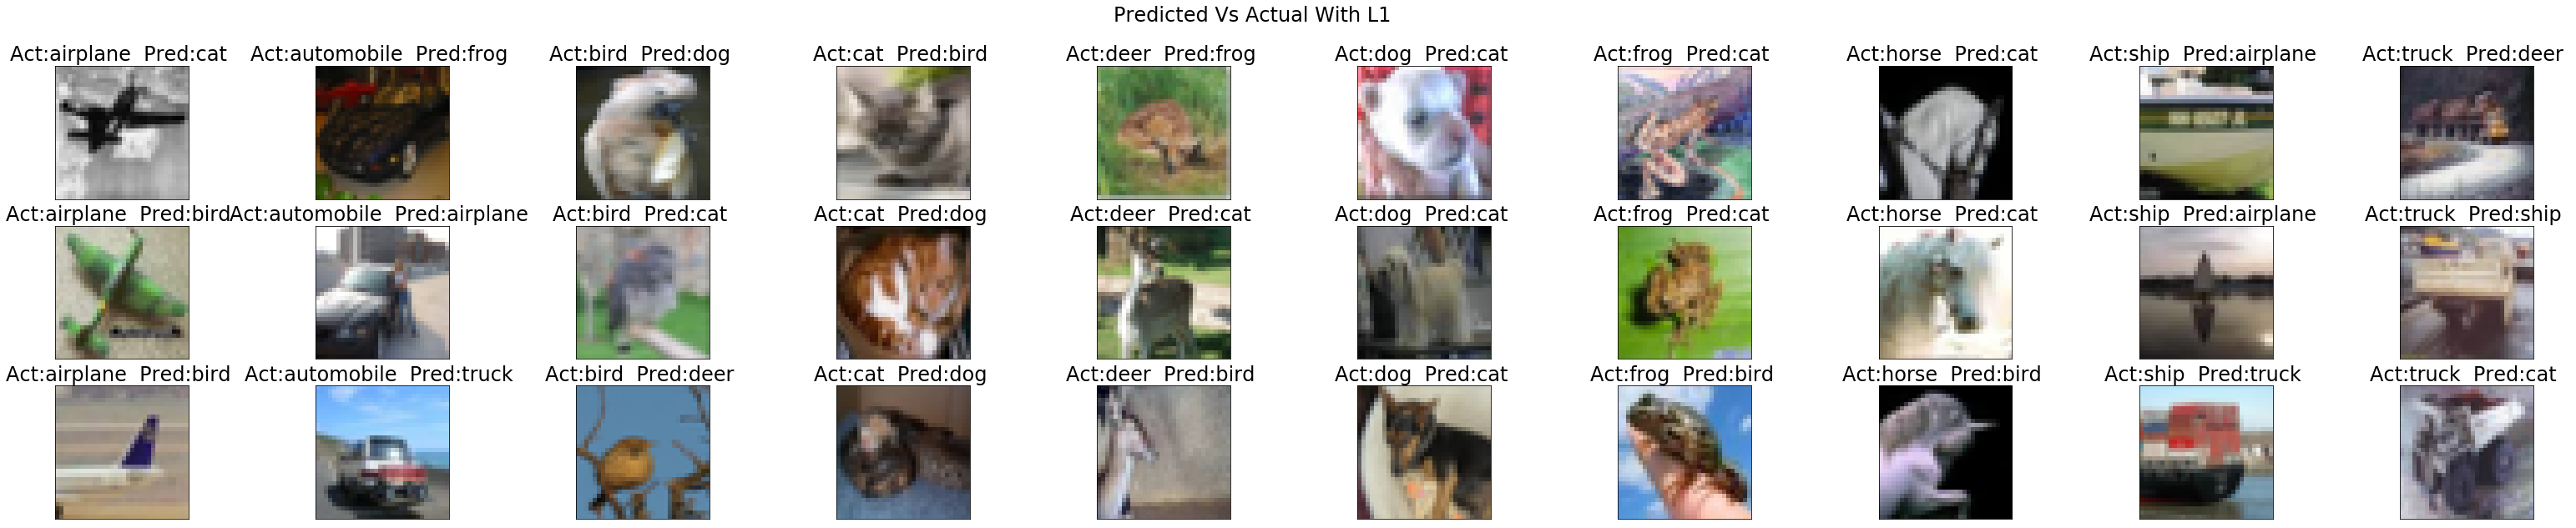

In [10]:
print("Model inference starts on {}  dataset".format(args.dataset))
#model_name = args.best_model
model_name = 'CIFAR10_model_epoch-42_L1-1_L2-0_val_acc-89.63.h5'
print("Loaded the best model: {} from last training session".format(model_name))
model = utils.load_model(resnet18.ResNet18(), device, model_name=model_name)
y_test = np.array(test_dataset.targets)
print("The confusion-matrix and classification-report for this model are:")
y_pred = utils.model_pred(model, device, y_test, test_dataset)
x_test = test_dataset.data
utils.display_mislabelled(model, device, x_test, y_test.reshape(-1, 1), y_pred, test_dataset, title_str='Predicted Vs Actual With L1')

### grad-cam displays "layer-2" (Resnet)

![title](./model_stacking.png)

![title](./model_layers.png)

### grad-cam displays "layer-2" (Resnet)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torch\nn\functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\ojhaj\Anaconda3\lib\site-packages\week7\modular\utils.py:206: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


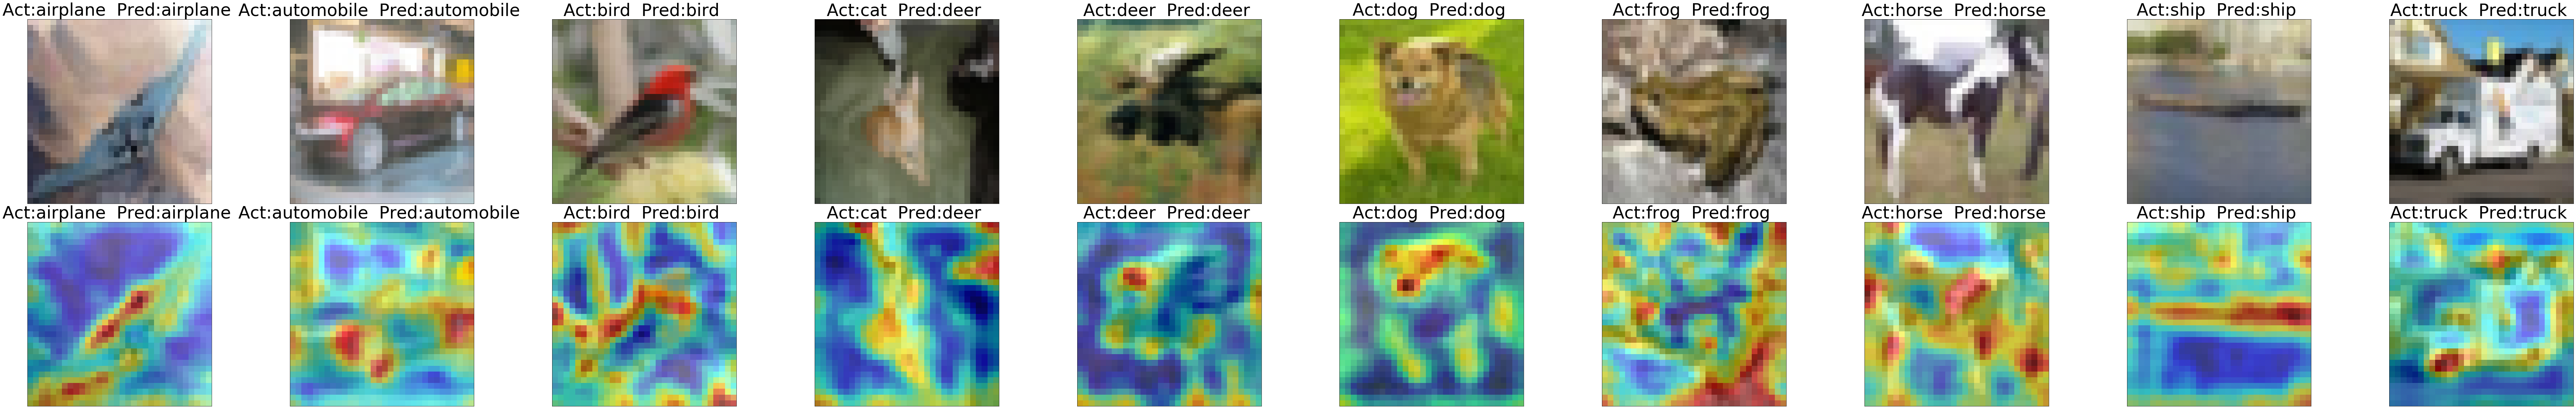

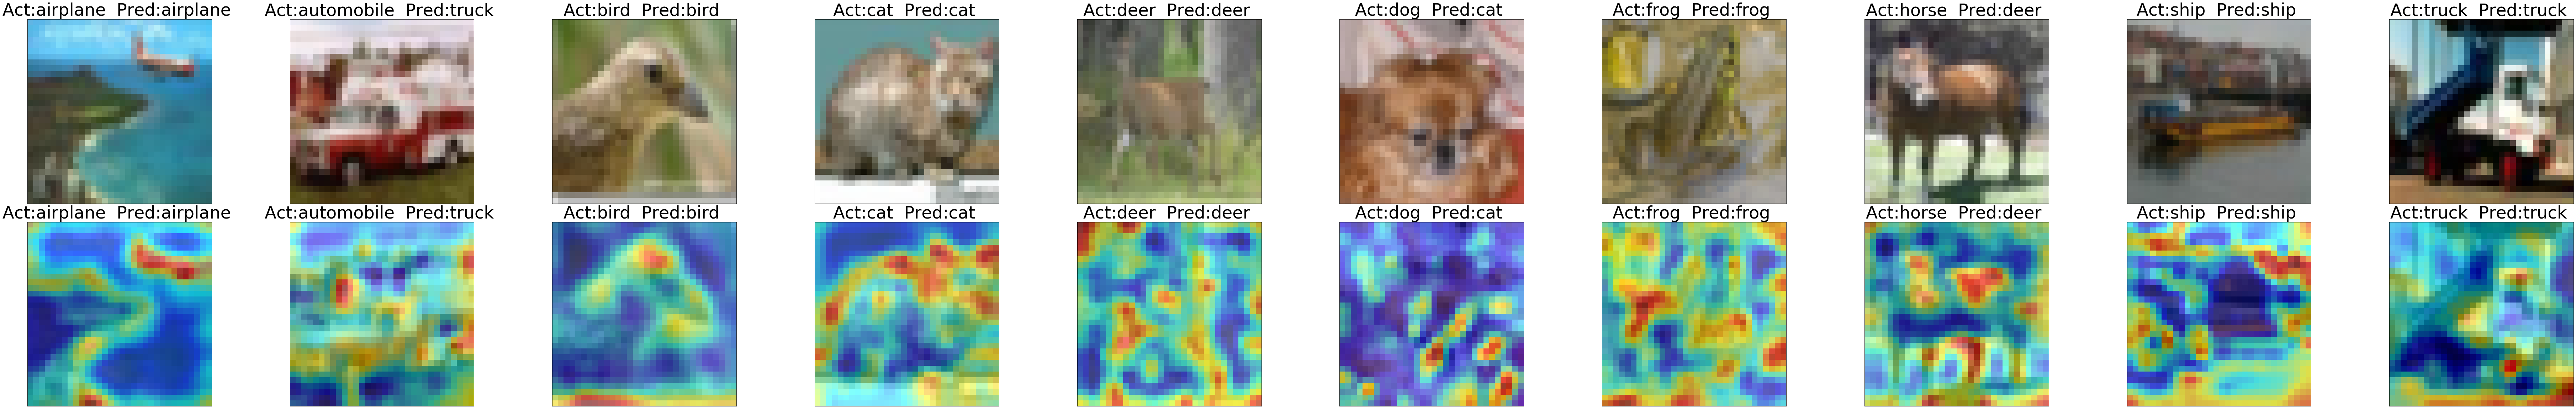

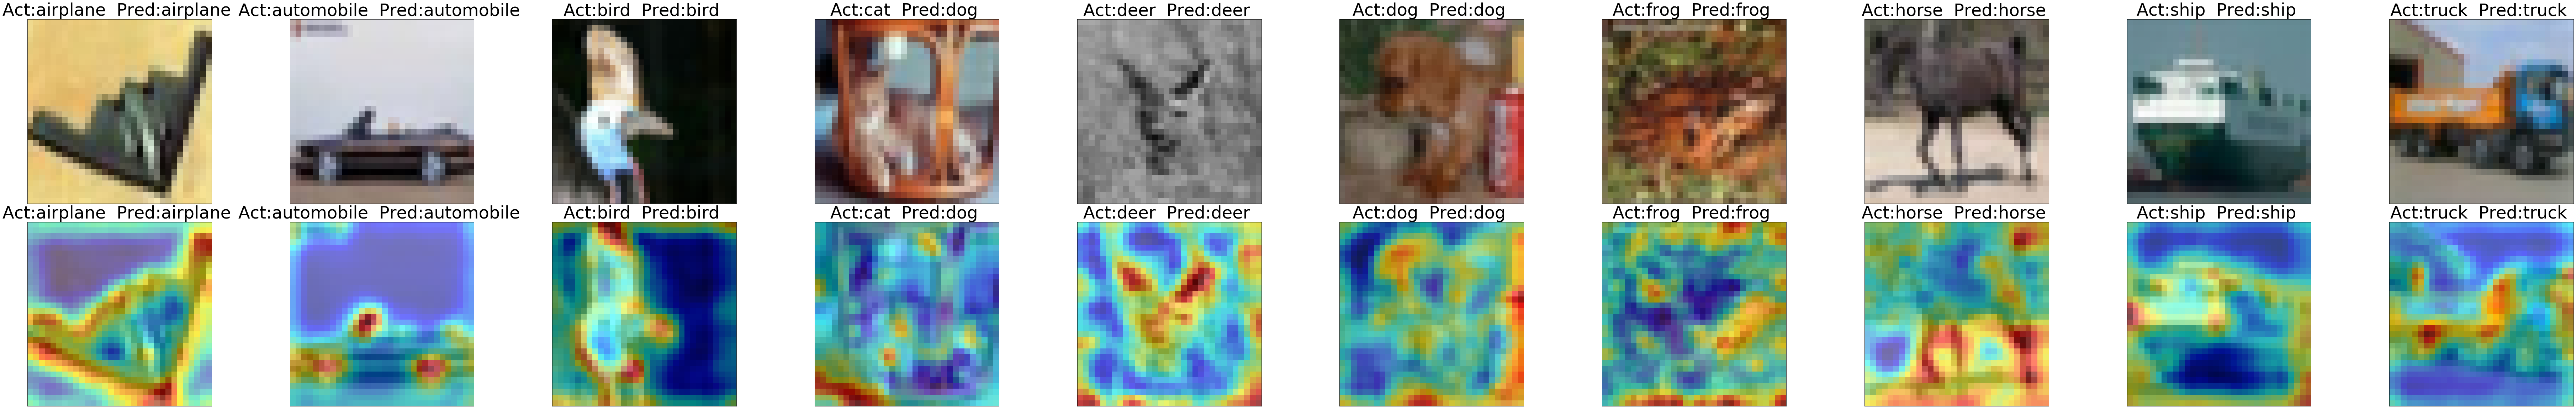

In [11]:
utils.show_gradcam(model, device, x_test, y_test, y_pred, test_dataset, mean_tuple, std_tuple, layer='layer2')

### grad-cam displays "layer-3" (Resnet)

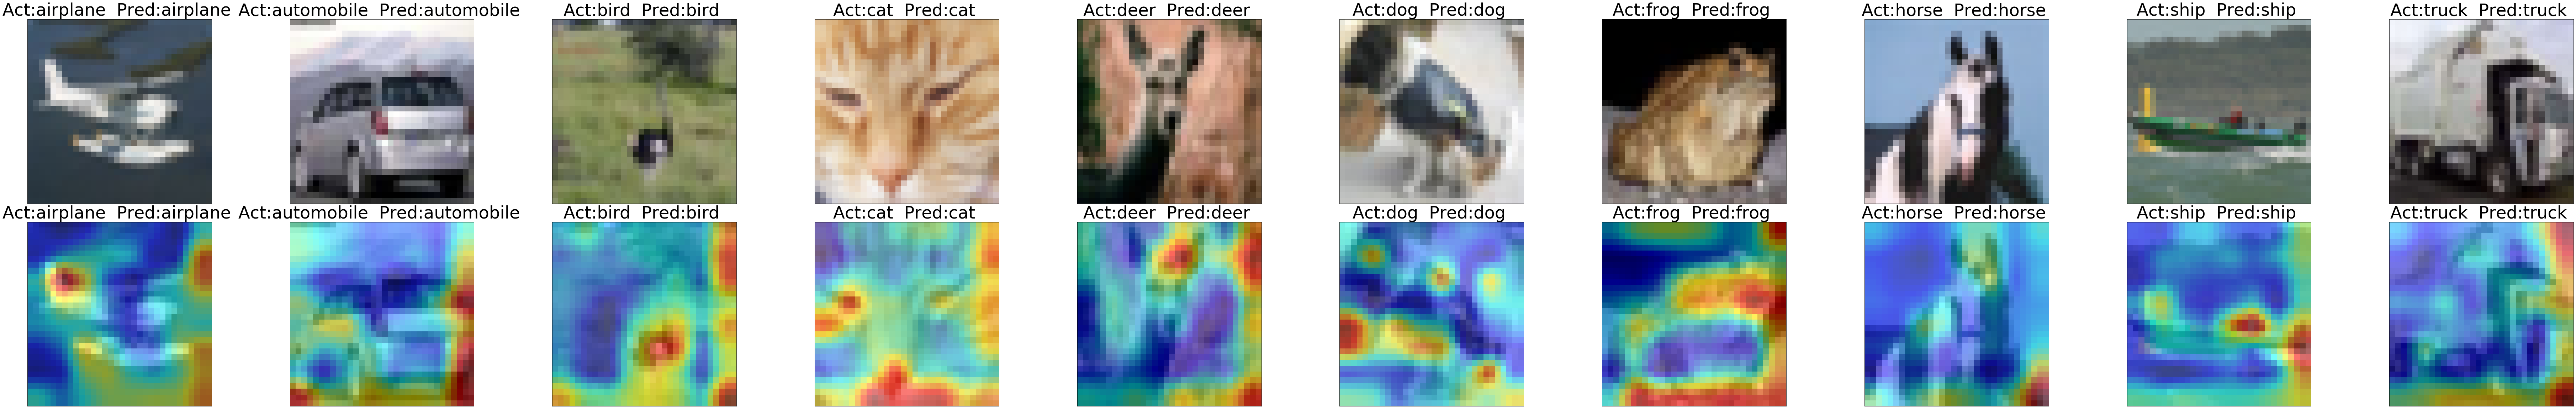

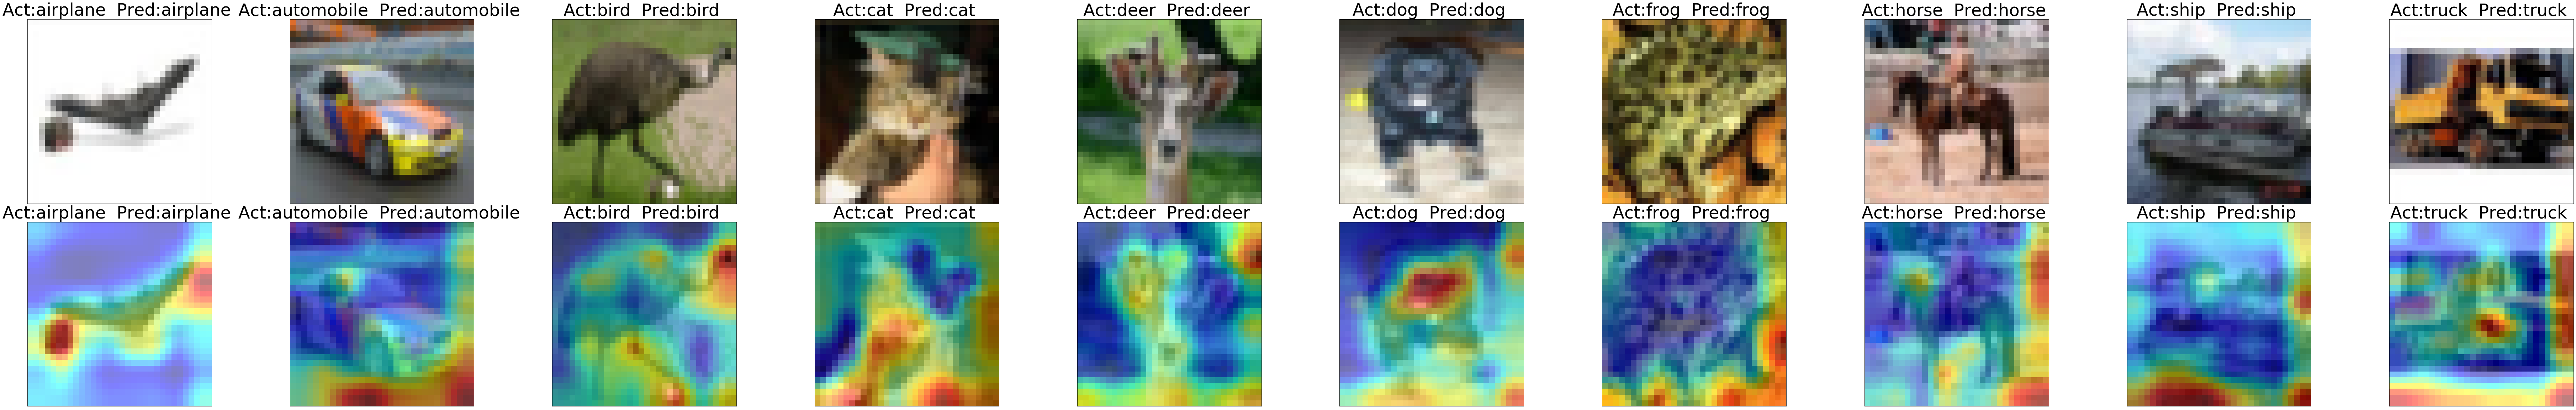

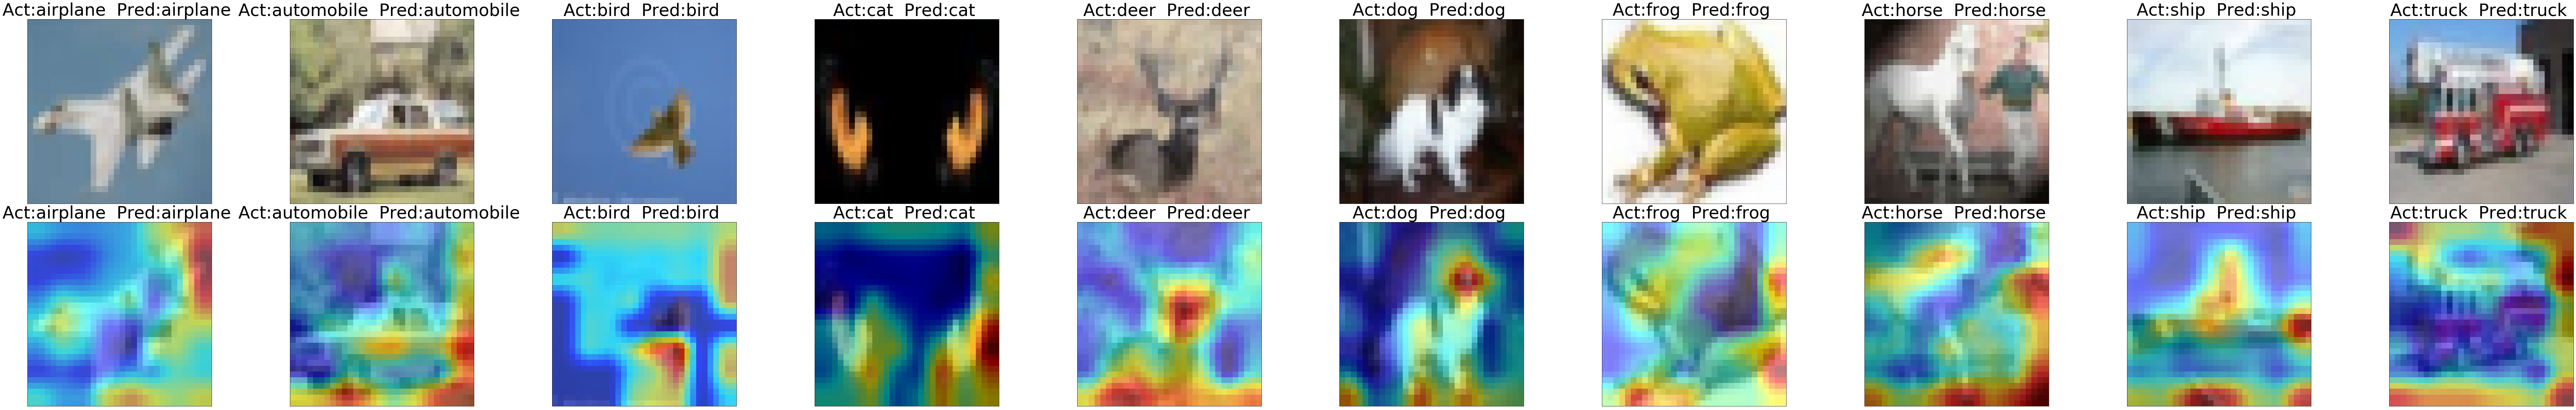

In [12]:
utils.show_gradcam(model, device, x_test, y_test, y_pred, test_dataset, mean_tuple, std_tuple, layer='layer3')

### grad-cam displays "layer-4" (Resnet)...the appropriate one to use for this case

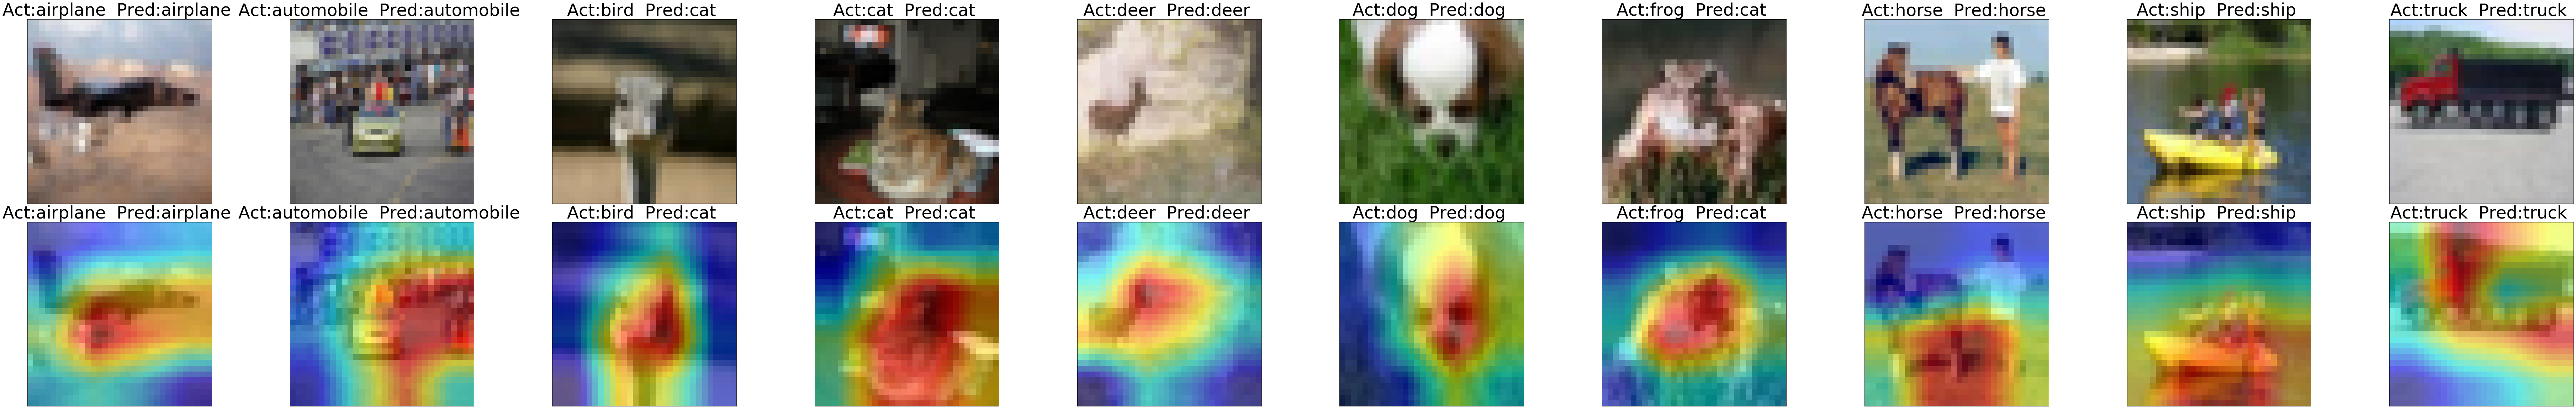

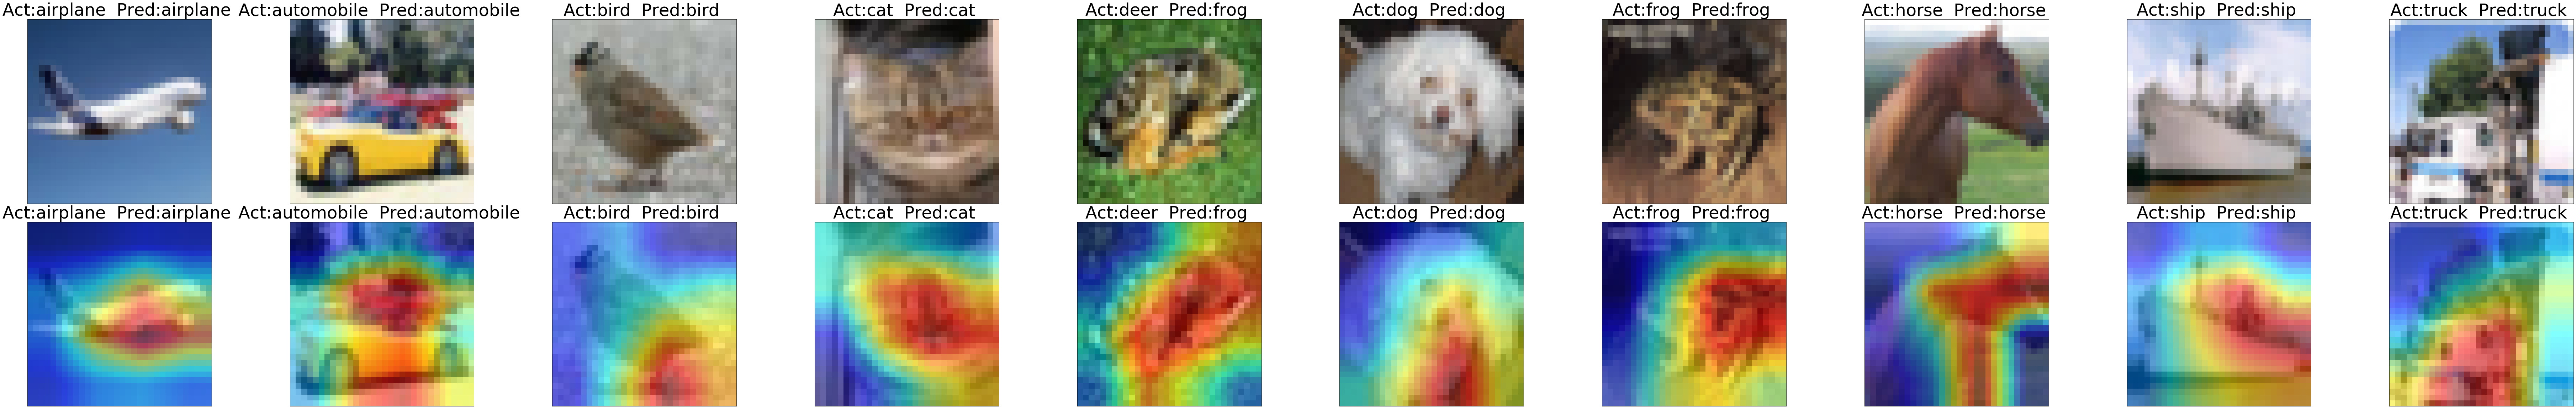

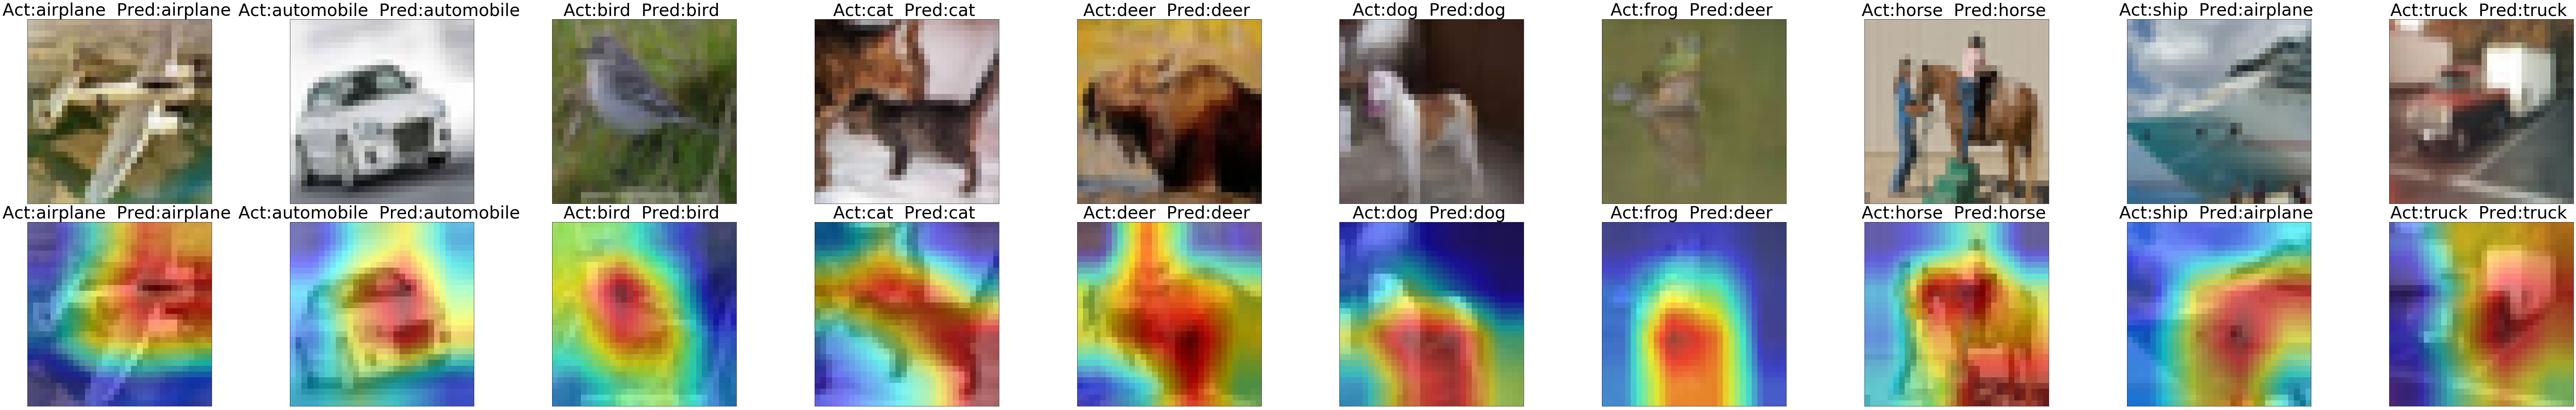

In [13]:
utils.show_gradcam(model, device, x_test, y_test, y_pred, test_dataset, mean_tuple, std_tuple, layer='layer4')

### grad-cam display mislabelled

C:\Users\ojhaj\Anaconda3\lib\site-packages\week7\modular\utils.py:273: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


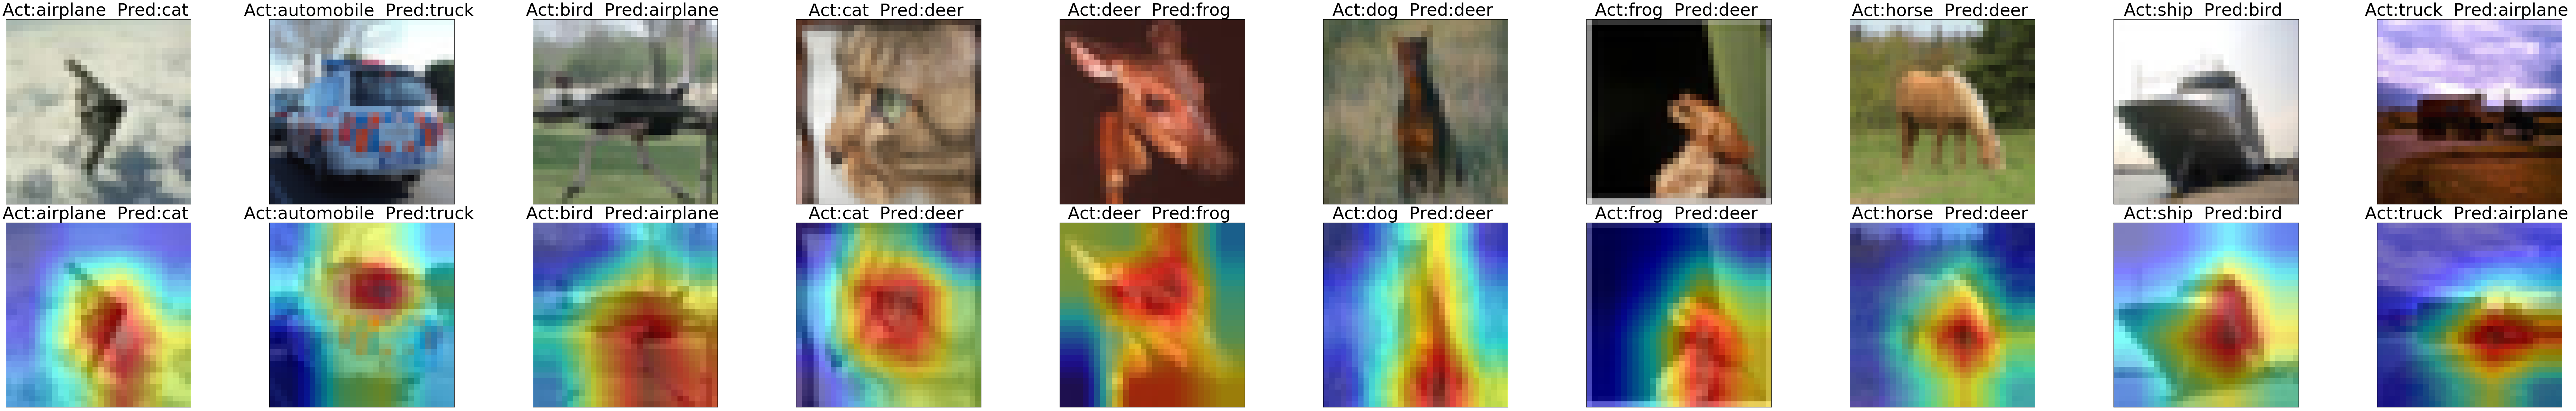

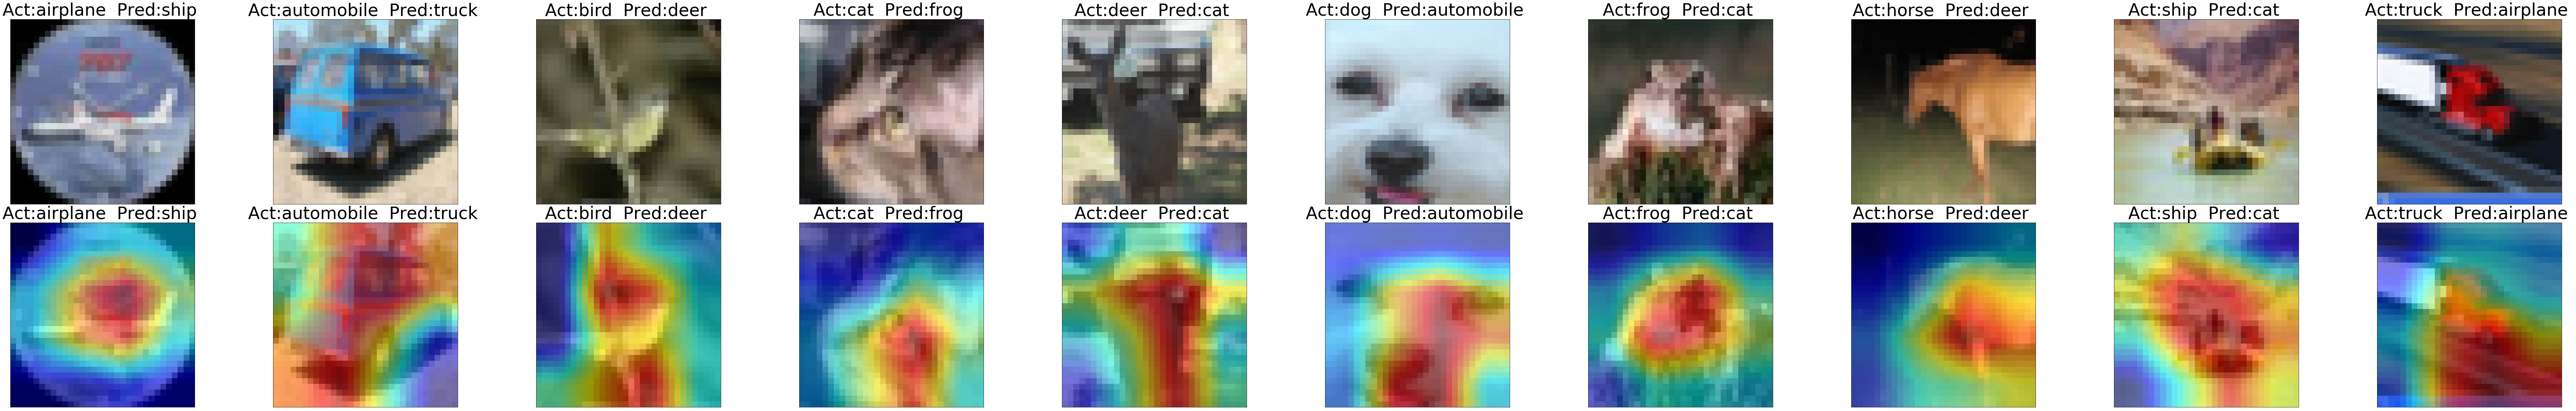

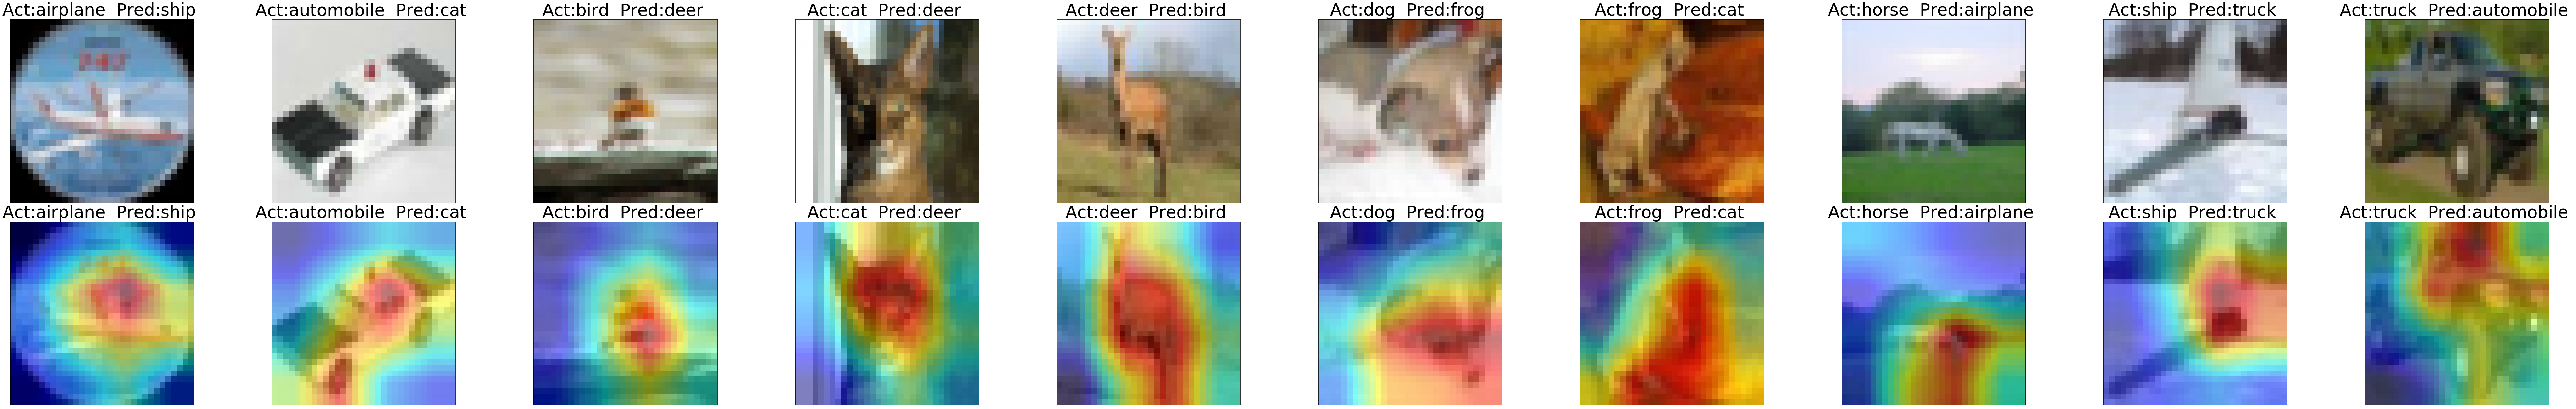

In [14]:
utils.show_gradcam_mislabelled(model, device, x_test, y_test.reshape(-1, 1), y_pred, test_dataset, mean_tuple, std_tuple, layer='layer4')